In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os

import logging as log

%matplotlib inline

In [2]:
log.getLogger().setLevel(20)

In [3]:
all_params = {}
all_runs = None

def get_params(run):
    result = {}
    params = ds[ds.type == "param"]
    for index, row in params[params.run == run].iterrows():
        # Try conversion. If fail, store string
        try:
            result[row.attrname] = float(row.attrvalue)
        except ValueError:
            result[row.attrname] = row.attrvalue
    return result

def build_params(ds):
    global all_params, all_runs
    
    all_params = {}
    all_runs = ds.run.unique()
    for run in all_runs:       
        all_params[run] = get_params(run)

In [4]:
run = "WarmUp*"
os.system(f"scavetool x ../results/{run}.sca ../results/{run}.vec -o /tmp/measurements.csv")
ds = pd.read_csv("/tmp/measurements.csv")
build_params(ds)

In [5]:
def find_runs(**params):
    global ds
    
    result = []
    
    for run in all_runs:       
        run_params = all_params[run]
                
        for name, value in params.items():
            if type(value) is str:
                check_value = '"'+value+'"'
            else:
                check_value = value
                
            if name not in run_params or run_params[name] != check_value:
                log.debug(f"{run_params} fails {name}, expected {check_value}, found {run_params[name] if name in run_params else 'None'}")
                break
        else: # loop was not interrupted 
            result.append(run)
                
    return result
                          
def find_run(**params):
    result = find_runs(**params)
    if len(result) == 0:
        log.warning("No run found")
        return None
    elif len(result) > 1:
        log.warning("Provided parameters match multiple runs.")
    
    return result[0]
   

In [6]:
def get_scalar(run, module, name):
    strvalue = ds[(ds.type == "scalar") & (ds.run == run) & (ds.name == name) & (ds.module == module)].iloc[0].value
    try:
        return float(strvalue)
    except ValueError:
        log.warning("Scalar is not a number: " + strvalue)
        return strvalue

def get_avg_rt(run, vip, compound):
    if run is None:
        log.error("Provided run is None")
        return None
                          
    name = ""
    if compound:
        name += "compound"
    else:
        name += "simple"

    if vip:
        name += "Vip"
    else:
        name += "Normal"

    name += "ResponseTime:mean"
    
    module = "Network.exit"
                          
    return get_scalar(run, module, name)

def get_avg_wt(run, module, vip):
    if run is None:
        log.error("Provided run is None")
        return None
                          
    name = ""

    if vip:
        name += "vip"
    else:
        name += "normal"

    name += "WaitingTime:mean"
    
    return get_scalar(run, module, name)

def get_avg_nq(run, module, vip = False, fifo = False):
    if run is None:
        log.error("Provided run is None")
        return None
                          
    name = ""

    if fifo:
        name += "fifo"
    elif vip:
        name += "vip"
    else:
        name += "normal"

    name += "QueueLength:timeavg"
    
    return get_scalar(run, module, name)
          

In [7]:
def get_vecvalue(run, module, name):
    try:
        return np.fromstring(ds[(ds.type == "vector") & (ds.run == run) & (ds.name == name) & (ds.module == module)].iloc[0].vecvalue, 
                             sep=" ", dtype=np.double)
    except Exception:
        log.warning("No vector found")
        return np.array([])
    
def get_vectime(run, module, name):
    try:
        return np.fromstring(ds[(ds.type == "vector") & (ds.run == run) & (ds.name == name) & (ds.module == module)].iloc[0].vectime, 
                             sep=" ", dtype=np.double)
    except Exception:
        log.warning("No vector found")
        return np.array([])

def get_rt(run, vip, compound):
    if run is None:
        log.error("Provided run is None")
        return None
                          
    name = ""
    if compound:
        name += "compound"
    else:
        name += "simple"

    if vip:
        name += "Vip"
    else:
        name += "Normal"

    name += "ResponseTime:vector"
    
    module = "Network.exit"
                          
    return get_vecvalue(run, module, name)

def get_rt_time(run, vip, compound):
    if run is None:
        log.error("Provided run is None")
        return None
                          
    name = ""
    if compound:
        name += "compound"
    else:
        name += "simple"

    if vip:
        name += "Vip"
    else:
        name += "Normal"

    name += "ResponseTime:vector"
    
    module = "Network.exit"
                          
    return get_vectime(run, module, name)

def get_wt(run, module, vip):
    if run is None:
        log.error("Provided run is None")
        return None
                          
    name = ""

    if vip:
        name += "vip"
    else:
        name += "normal"

    name += "WaitingTime:vector"
    
    return get_vecvalue(run, module, name)

def get_wt_time(run, module, vip):
    if run is None:
        log.error("Provided run is None")
        return None
                          
    name = ""

    if vip:
        name += "vip"
    else:
        name += "normal"

    name += "WaitingTime:vector"
    
    return get_vectime(run, module, name)

In [8]:
def hol_wait_time(vip, normArrivalRate, vipArrivalRate, serviceRate):
    if not vip:
        return ((normArrivalRate + vipArrivalRate)/((serviceRate-vipArrivalRate)*(serviceRate-normArrivalRate-vipArrivalRate)))
    else:
        return ((normArrivalRate + vipArrivalRate)/(serviceRate*(serviceRate-vipArrivalRate)))
    
def hol_resp_time(vip, normArrivalRate, vipArrivalRate, serviceRate):
    return hol_wait_time(vip, normArrivalRate, vipArrivalRate, serviceRate) + 1 / serviceRate

In [9]:
def mm1_resp_time(arrivalRate, serviceRate):
    return 1/(serviceRate - arrivalRate)

def mm1_wait_time(arrivalRate, serviceRate):
    return mm1_resp_time(arrivalRate, serviceRate) - 1/serviceRate

def mm1_queue_length(arrivalRate, serviceRate):
    rho = arrivalRate/serviceRate
    return rho/(1-rho)-rho

In [10]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    ret[n-1:] = ret[n - 1:] / n
    ret[:n-1] = ret[:n-1] / np.arange(1,n)
    return ret

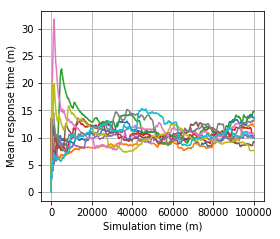

In [15]:
runs = find_runs()
fig = plt.figure(figsize=(4,3.5))
for run in runs:
    args = [run, False, False]
    raw = get_rt(*args)
    y = moving_average(raw, n=len(raw)//25)
    x = get_rt_time(*args)
    t = 100000
    plt.plot(x[x<t],y[x<t])
plt.grid(True, 'both')
plt.xlabel("Simulation time (m)")
plt.ylabel("Mean response time (m)")
plt.savefig('/tmp/fig.pdf', bbox_inches='tight')

<BarContainer object of 18 artists>

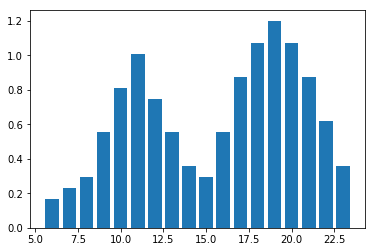